#📌 Extracción

In [22]:
import pandas as pd
import requests

# Cargar el JSON desde la URL
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)

# Ver los primeros registros
df.head(1)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."


#🔧 Transformación

In [50]:
# Convert dicts/listas residuales a string para evitar errores
for col in df.columns:
    df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (dict, list)) else x)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace('.', '_').str.replace(' ', '_')

# Limpiar texto en columnas categóricas
cols_cat = [col for col in df.columns if df[col].dtype == 'object']
for col in cols_cat:
    df[col] = df[col].str.strip().str.lower()

# Eliminar duplicados
df = df.drop_duplicates()

# Mostrar resumen de valores nulos
nulos = df.isnull().sum()
porcentaje = (nulos / len(df)) * 100
print("📌 Valores nulos por columna:")
print(pd.DataFrame({'nulos': nulos, 'porcentaje': porcentaje}).query('nulos > 0').sort_values(by='porcentaje', ascending=False))

# Mostrar estadísticas numéricas
print("\n📊 Estadísticas numéricas:")
print(df.describe())

# Verificar consistencias lógicas (ejemplo)
if 'internet_internetservice' in df.columns and 'internet_streamingtv' in df.columns:
    inconsistentes = df[(df['internet_internetservice'] == 'no') & (df['internet_streamingtv'] != 'no')]
    print(f"\n⚠️ Registros inconsistentes entre servicio de internet y streaming TV: {len(inconsistentes)}")

📌 Valores nulos por columna:
Empty DataFrame
Columns: [nulos, porcentaje]
Index: []

📊 Estadísticas numéricas:
       customer_seniorcitizen  customer_tenure  account_charges_monthly
count             7267.000000      7267.000000              7267.000000
mean                 0.162653        32.346498                64.720098
std                  0.369074        24.571773                30.129572
min                  0.000000         0.000000                18.250000
25%                  0.000000         9.000000                35.425000
50%                  0.000000        29.000000                70.300000
75%                  0.000000        55.000000                89.875000
max                  1.000000        72.000000               118.750000

⚠️ Registros inconsistentes entre servicio de internet y streaming TV: 1581


In [55]:

def limpiar_dataset_churn(df):

    # 1. Imputación de valores nulos
    df['account_charges_total'] = df['account_charges_total'].fillna(df['account_charges_total'].median())
    df['internet_techsupport'] = df['internet_techsupport'].fillna('no informado')

    # 2. Eliminación de duplicados
    df = df.drop_duplicates()

    # 3. Corrección de categorías inconsistentes
    df['account_contract'] = df['account_contract'].replace({
        'month-to-month': 'mensual',
        'one year': 'anual',
        'two year': 'bienal'
    })

    # 4. Normalización de fechas
    if 'account_created' in df.columns:
        df['account_created'] = pd.to_datetime(df['account_created'], errors='coerce')
        df['account_created'] = df['account_created'].dt.normalize()

    # 5. Corrección lógica: sin internet → sin servicios asociados
    sin_internet = df['internet_internetservice'] == 'no'
    columnas_internet = [
        'internet_streamingtv', 'internet_streamingmovies',
        'internet_onlinebackup', 'internet_deviceprotection',
        'internet_techsupport'
    ]
    df.loc[sin_internet, columnas_internet] = 'no'

    return df

print("✅ Dataset limpio:")
print(df.info())
print(df.describe(include='all'))


✅ Dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7267 non-null   object 
 1   churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_seniorcitizen     7267 non-null   int64  
 4   customer_partner           7267 non-null   object 
 5   customer_dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_phoneservice         7267 non-null   object 
 8   phone_multiplelines        7267 non-null   object 
 9   internet_internetservice   7267 non-null   object 
 10  internet_onlinesecurity    7267 non-null   object 
 11  internet_onlinebackup      7267 non-null   object 
 12  internet_deviceprotection  7267 non-null   object 
 13  internet_techsupport       726

In [58]:
# Convert 'account_charges_total' to numeric, coercing errors
df['account_charges_total'] = pd.to_numeric(df['account_charges_total'], errors='coerce')

# Create columna Cuentas_Diarias
df['Cuentas_Diarias'] = df['account_charges_total'] / 30

# Crear columna con días según tipo de contrato
# Correct the keys to match the values in 'tipo_contrato' after renaming and lowercasing
dias_por_contrato = {
    'mensual': 30,
    'anual': 365,
    'bienal': 730
}

# Assuming 'tipo_contrato' is the column with contract types after processing in bGuXK72nJAEH
# Ensure the mapping uses the correct case for the keys
dias_por_contrato_corrected_keys = {
    'mensual': 30,
    'anual': 365,
    'bienal': 730
}

# Need to make sure 'tipo_contrato' column exists and has the expected values before mapping
# Based on bGuXK72nJAEH, 'tipo_contrato' values are 'Mensual', 'Anual', 'Bienal' (initial cap)
# Let's use the values with initial caps in the mapping dictionary keys for now to match
# the state of df after bGuXK72nJAEH executes.
dias_por_contrato_case_sensitive = {
    'Mensual': 30,
    'Anual': 365,
    'Bienal': 730
}


# Check if 'tipo_contrato' column exists before mapping
if 'tipo_contrato' in df.columns:
    df['dias_contrato'] = df['tipo_contrato'].map(dias_por_contrato_case_sensitive)
    # Recalculate Cuentas_Diarias using dias_contrato
    # Handle potential division by zero or NaN in dias_contrato
    df['Cuentas_Diarias'] = df['account_charges_total'] / df['dias_contrato']
else:
    print("Warning: 'tipo_contrato' column not found. Cannot calculate 'dias_contrato' and 'Cuentas_Diarias' based on contract type.")
    df['dias_contrato'] = pd.NA # Assign pandas Not Available
    df['Cuentas_Diarias'] = df['account_charges_total'] / 30 # Fallback to monthly calculation


print(df[['account_charges_total', 'tipo_contrato', 'dias_contrato', 'Cuentas_Diarias']].head()) # Include dias_contrato in print

   account_charges_total account_contract  Cuentas_Diarias
0                 593.30         one year              NaN
1                 542.40   month-to-month              NaN
2                 280.85   month-to-month              NaN
3                1237.85   month-to-month              NaN
4                 267.40   month-to-month              NaN


In [61]:
import pandas as pd

# Ejemplo: convertir columnas de servicios en binarios
binarias = [
    'internet_streamingtv', 'internet_streamingmovies',
    'internet_onlinebackup', 'internet_deviceprotection',
    'internet_techsupport', 'internet_onlinesecurity' # Added online security
]

# Update the mapping to include 'no internet service' and use lowercase keys to match cleaned column values
binary_mapping = {'yes': 1, 'no': 0, 'no internet service': 0, 'no informado': None}


for col in binarias:
    if col in df.columns: # Check if column exists
        df[col] = df[col].map(binary_mapping)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


# Rename columns
df.rename(columns={
    'account_charges_total': 'Total_Mensual',
    'account_contract': 'Tipo_Contrato',
    'account_created': 'Fecha_Creación',
    'Cuentas_Diarias': 'Total_Diario',
    'account_paymentmethod': 'PaymentMethod' # Rename payment method column as well
}, inplace=True)

# Clean column names (lowercase and replace spaces with underscores)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Correct the contract type values after renaming the column - ensure consistent case for mapping later
# Let's convert them to lowercase to match the corrected mapping in OcWrdBcRIix0
if 'tipo_contrato' in df.columns:
    df['tipo_contrato'] = df['tipo_contrato'].replace({
        'month-to-month': 'mensual',
        'one year': 'anual',
        'two year': 'bienal'
    }).str.lower() # Convert to lowercase


# Create dummy variables using the corrected column names - ensure column names are correct after lowercasing
dummy_cols = []
if 'paymentmethod' in df.columns:
    dummy_cols.append('paymentmethod')
if 'tipo_contrato' in df.columns:
    dummy_cols.append('tipo_contrato')


if dummy_cols:
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
else:
    print("Warning: No columns found to create dummy variables for payment method or contract type.")


print("✅ Dataset estandarizado:")
print(df.head())
print(df.info())

✅ Dataset estandarizado:
   customerid churn customer_gender  customer_seniorcitizen customer_partner  \
0  0002-orfbo    no          female                       0              yes   
1  0003-mknfe    no            male                       0               no   
2  0004-tlhlj   yes            male                       0               no   
3  0011-igkff   yes            male                       1              yes   
4  0013-exchz   yes          female                       1              yes   

  customer_dependents  customer_tenure phone_phoneservice phone_multiplelines  \
0                 yes                9                yes                  no   
1                  no                9                yes                 yes   
2                  no                4                yes                  no   
3                  no               13                yes                  no   
4                  no                3                yes                  no   

  inter

#📊 Carga y análisis

📊 Análisis Descriptivo - Métricas Numéricas
       customer_seniorcitizen  customer_tenure  internet_onlinebackup  \
count                 7267.00          7267.00                    0.0   
mean                     0.16            32.35                    NaN   
std                      0.37            24.57                    NaN   
min                      0.00             0.00                    NaN   
25%                      0.00             9.00                    NaN   
50%                      0.00            29.00                    NaN   
75%                      0.00            55.00                    NaN   
max                      1.00            72.00                    NaN   

       internet_deviceprotection  internet_techsupport  internet_streamingtv  \
count                        0.0                   0.0                   0.0   
mean                         NaN                   NaN                   NaN   
std                          NaN                   NaN    

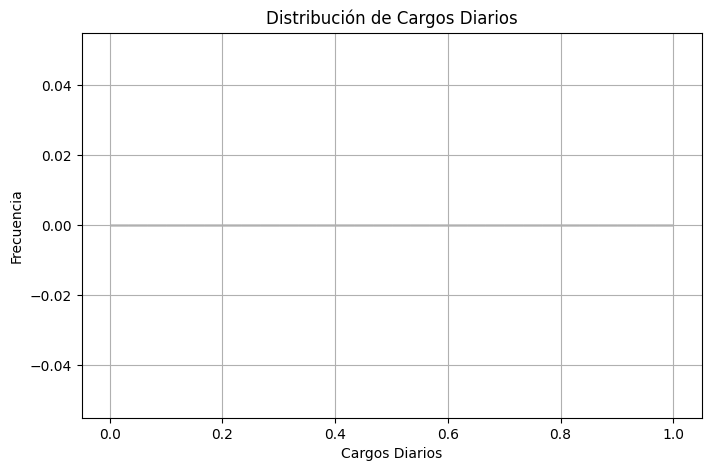

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analisis_descriptivo(df):


    print("📊 Análisis Descriptivo - Métricas Numéricas")
    print(df.describe().round(2))

    print("\n🔠 Análisis Descriptivo - Variables Categóricas")
    # Select columns with object dtype for categorical analysis
    categorical_cols = df.select_dtypes(include='object').columns
    if not categorical_cols.empty:
        print(df[categorical_cols].describe())
    else:
        print("No categorical columns found.")


    print("\n📌 Distribución de cargos diarios")
    # Check if 'Total_Diario' exists before printing statistics
    if 'total_diario' in df.columns and df['total_diario'].notna().any():
        print("Media:", round(df['total_diario'].mean(), 2))
        print("Mediana:", round(df['total_diario'].median(), 2))
        print("Desviación estándar:", round(df['total_diario'].std(), 2))
        print("Máximo:", round(df['total_diario'].max(), 2))
        print("Mínimo:", round(df['total_diario'].min(), 2))
    else:
        print("'Total_Diario' column not available or contains only NaN values.")


    print("\n📈 Frecuencia por tipo de contrato")
    # Check if 'tipo_contrato' exists before printing value counts
    if 'tipo_contrato' in df.columns:
        print(df['tipo_contrato'].value_counts())
    else:
        print("'tipo_contrato' column not available.")


    print("\n📉 Frecuencia de clientes por servicio de streaming")
    if 'internet_streamingtv' in df.columns:
        print(df['internet_streamingtv'].value_counts())
    else:
         print("'internet_streamingtv' column not available.")


    print("\n✅ Revisión completa. Dataset listo para visualización o modelado.")

analisis_descriptivo(df)


plt.figure(figsize=(8,5))
sns.histplot(df['total_diario'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Cargos Diarios')
plt.xlabel('Cargos Diarios')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

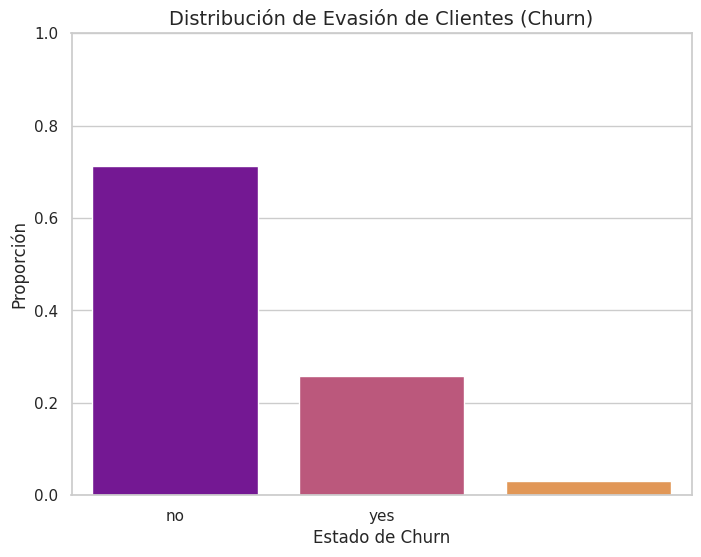

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo de los gráficos
sns.set(style="whitegrid")


# Calcular proporciones
distribution = df['churn'].value_counts(normalize=True).reset_index()
distribution.columns = ['churn', 'proportion']

# Visualización
plt.figure(figsize=(8, 6))
sns.barplot(x='churn', y='proportion', hue='churn', data=distribution, palette='plasma', legend=False)
plt.title('Distribución de Evasión de Clientes (Churn)', fontsize=14)
plt.xlabel('Estado de Churn')
plt.ylabel('Proporción')
plt.ylim(0, 1)
plt.show()



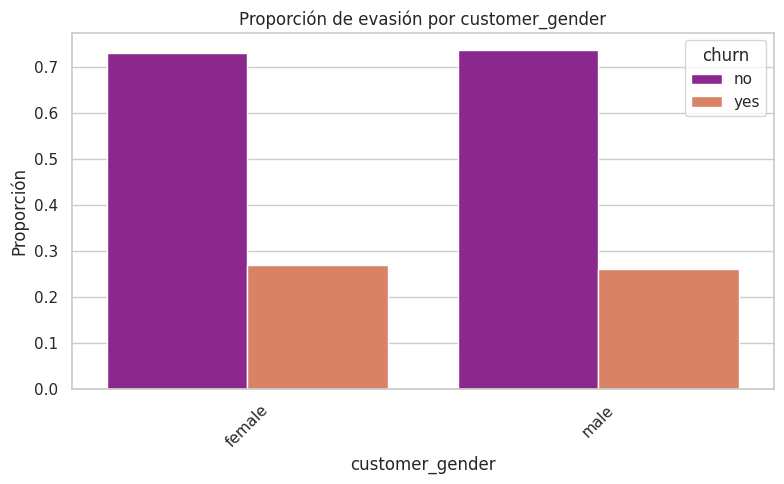


📈 Proporción de evasión por Tipo de Contrato:


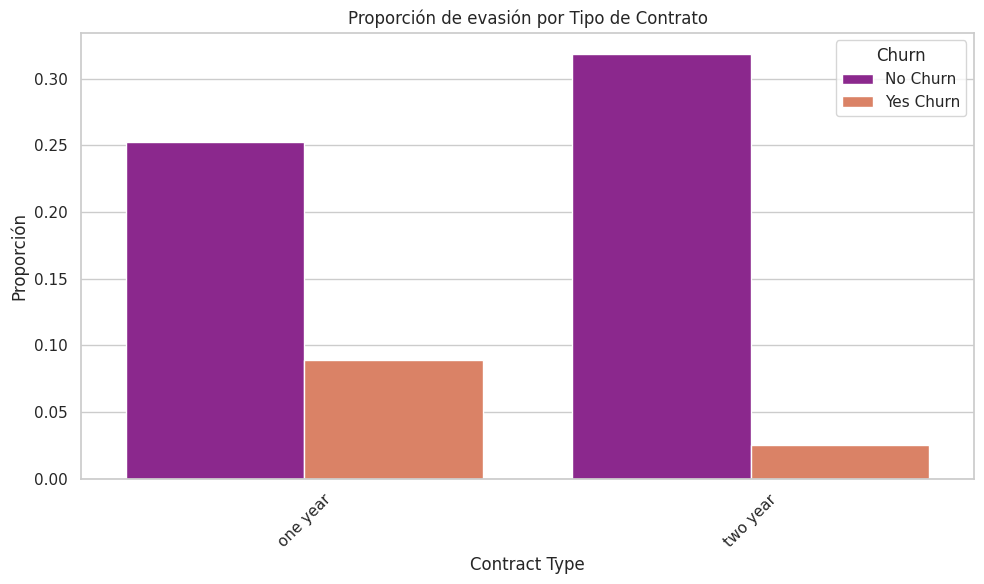


💳 Proporción de evasión por Método de Pago:


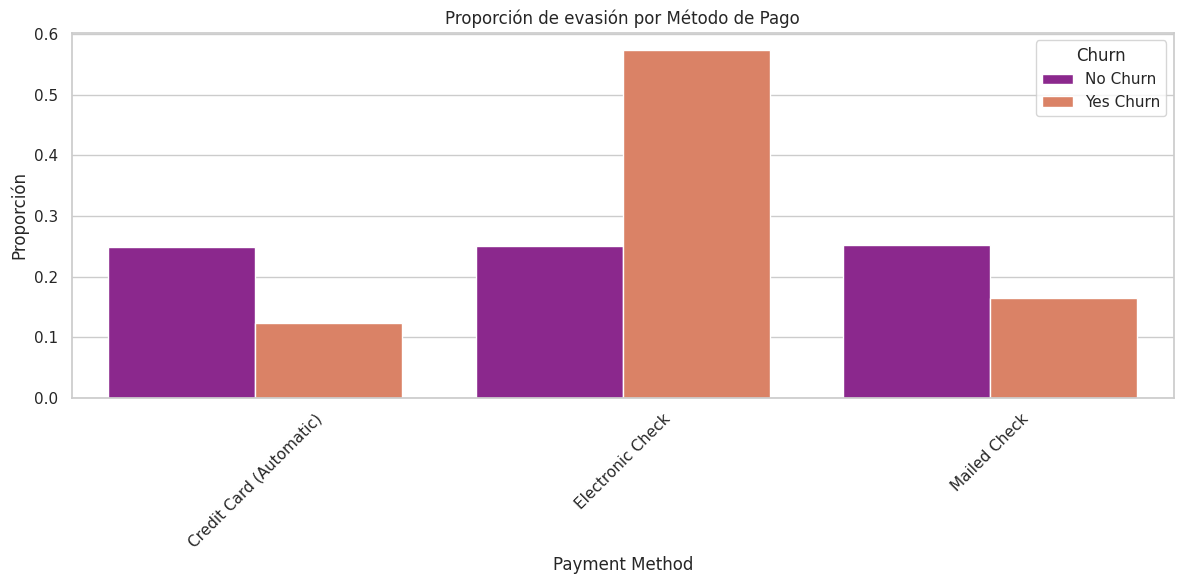


✅ Análisis de evasión por categorías completado.


In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo
sns.set(style="whitegrid")

def analizar_evasion_por_categoria(df, categoria, churn_col='churn'):
    """Analiza y visualiza la proporción de churn para una columna categórica."""
    # Agrupamos y calculamos proporciones
    conteo = df.groupby([categoria, churn_col]).size().reset_index(name='count')
    total_por_categoria = df.groupby(categoria).size().reset_index(name='total')
    distribucion = pd.merge(conteo, total_por_categoria, on=categoria)
    distribucion['proporcion'] = distribucion['count'] / distribucion['total']

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.barplot(x=categoria, y='proporcion', hue=churn_col, data=distribucion, palette='plasma')
    plt.title(f'Proporción de evasión por {categoria}')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze churn by customer gender using the existing function
# Ensure 'churn' column only contains 'no' and 'yes' for this analysis as well
df_filtered_churn = df[df['churn'].isin(['no', 'yes'])].copy()
analizar_evasion_por_categoria(df_filtered_churn, categoria='customer_gender')


# Analyze churn by contract type using dummy variables
contract_cols = [col for col in df.columns if col.startswith('tipo_contrato_')]
if contract_cols:
    print("\n📈 Proporción de evasión por Tipo de Contrato:")
    # Filter out rows with empty string in churn before grouping
    contract_churn = df[df['churn'].isin(['no', 'yes'])].groupby('churn')[contract_cols].mean().T.reset_index()
    contract_churn.columns = ['Contract Type', 'No Churn', 'Yes Churn'] # Assuming 'no' and 'yes' are churn values
    contract_churn['Contract Type'] = contract_churn['Contract Type'].str.replace('tipo_contrato_', '') # Clean up names

    plt.figure(figsize=(10, 6))
    contract_churn_melted = contract_churn.melt(id_vars='Contract Type', var_name='Churn', value_name='Proportion')
    sns.barplot(x='Contract Type', y='Proportion', hue='Churn', data=contract_churn_melted, palette='plasma')
    plt.title('Proporción de evasión por Tipo de Contrato')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No se encontraron columnas de tipo de contrato (dummy variables).")


# Analyze churn by payment method using dummy variables
payment_cols = [col for col in df.columns if col.startswith('paymentmethod_')]
if payment_cols:
    print("\n💳 Proporción de evasión por Método de Pago:")
    # Filter out rows with empty string in churn before grouping
    payment_churn = df[df['churn'].isin(['no', 'yes'])].groupby('churn')[payment_cols].mean().T.reset_index()
    payment_churn.columns = ['Payment Method', 'No Churn', 'Yes Churn'] # Assuming 'no' and 'yes' are churn values
    payment_churn['Payment Method'] = payment_churn['Payment Method'].str.replace('paymentmethod_', '').str.replace('_', ' ').str.title() # Clean up names

    plt.figure(figsize=(12, 6))
    payment_churn_melted = payment_churn.melt(id_vars='Payment Method', var_name='Churn', value_name='Proportion')
    sns.barplot(x='Payment Method', y='Proportion', hue='Churn', data=payment_churn_melted, palette='plasma')
    plt.title('Proporción de evasión por Método de Pago')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
     print("\n⚠️ No se encontraron columnas de método de pago (dummy variables).")


print("\n✅ Análisis de evasión por categorías completado.")

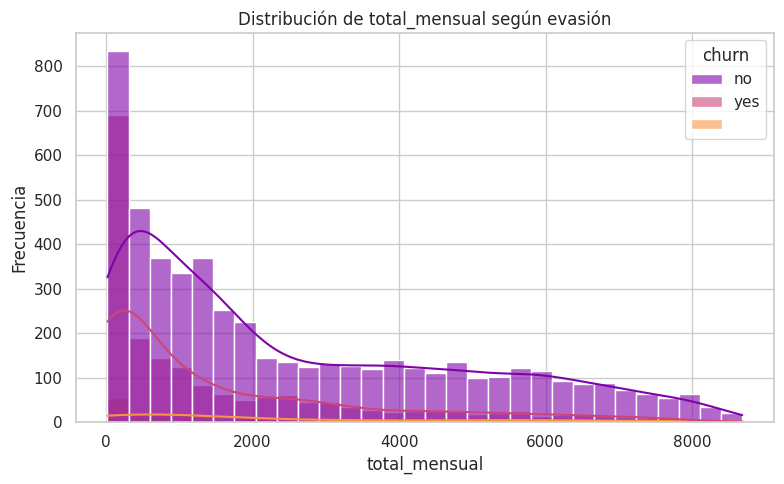

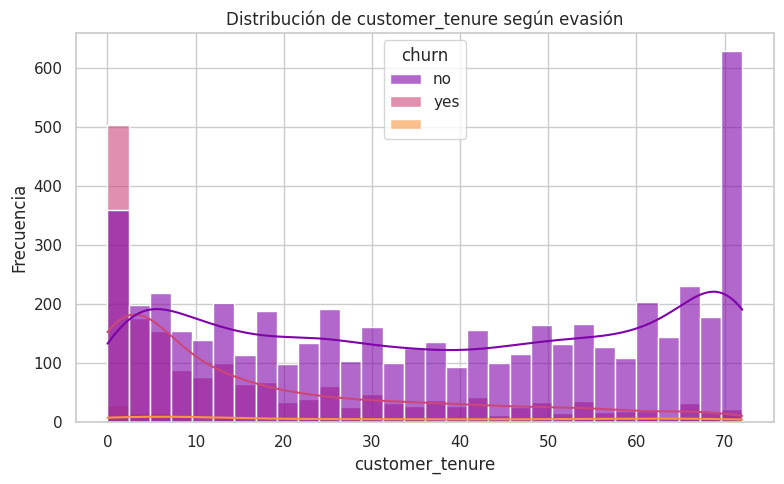

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def analizar_evasion_por_numerica(df, columna_numerica, churn_col='churn', bins=30):

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=columna_numerica, hue=churn_col, bins=bins, kde=True, palette='plasma', alpha=0.6)
    plt.title(f'Distribución de {columna_numerica} según evasión')
    plt.xlabel(columna_numerica)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

    # Lista de columnas numéricas a explorar
numericas = ['total_mensual', 'customer_tenure']  # Adjusted to correct column names

for col in numericas:
    analizar_evasion_por_numerica(df, columna_numerica=col)

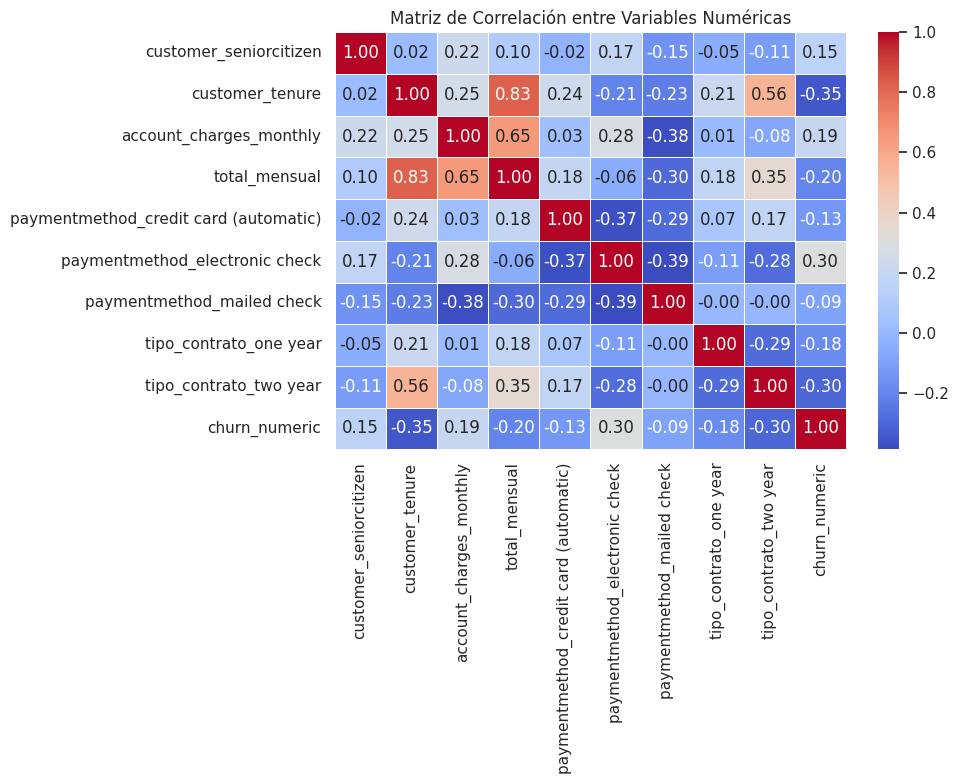

Skipping boxplot for total_diario as it contains no non-NaN values.


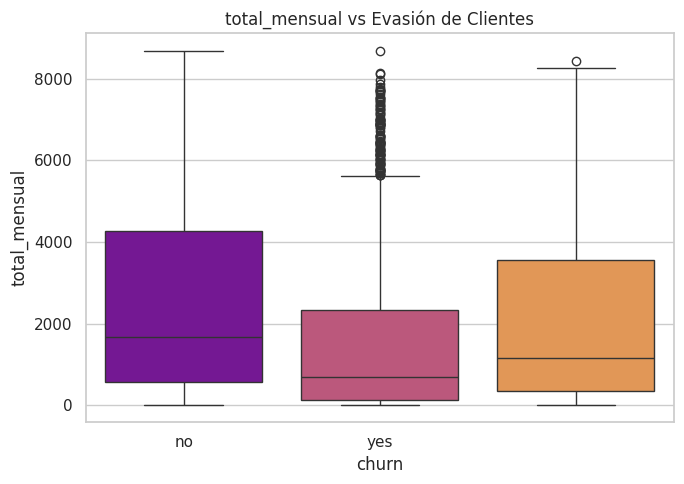

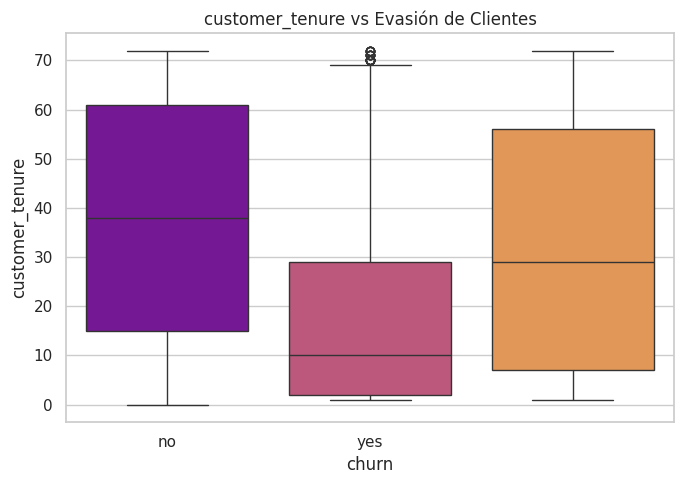

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertimos churn a numérico si es categórico
# Handle empty strings in 'churn' column by mapping them to NaN or a different value
df['churn_numeric'] = df['churn'].map({'yes': 1, 'no': 0, '': None}) # Map empty string to None (NaN)

# Seleccionamos solo columnas numéricas
numericas = df.select_dtypes(include=['number', 'bool']) # Include boolean columns as they are treated as numeric

# Calculamos matriz de correlación
# Drop columns that have only NaN values before calculating correlation
numericas_cleaned = numericas.dropna(axis=1, how='all')
correlaciones = numericas_cleaned.corr()


# Visualización
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()

def dispersión_vs_churn(df, columna_numerica):
    """
    Muestra gráfico de dispersión entre una variable numérica y evasión.
    """
    # Filter out rows where the numeric column is NaN to avoid errors in boxplot
    df_filtered = df.dropna(subset=[columna_numerica])
    if not df_filtered.empty:
        plt.figure(figsize=(7, 5))
        sns.boxplot(x='churn', y=columna_numerica, hue='churn', data=df_filtered, palette='plasma', legend=False)
        plt.title(f'{columna_numerica} vs Evasión de Clientes')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping boxplot for {columna_numerica} as it contains no non-NaN values.")


# Variables a explorar for boxplot
# Using 'total_diario' for daily charges, removing 'num_services' as it doesn't exist
variables_a_explorar = ['total_diario', 'total_mensual', 'customer_tenure']


for var in variables_a_explorar:
    dispersión_vs_churn(df, var)

#📄Informe final

# 📊 Informe Final: Análisis de Evasión de Clientes (Churn)

## 🔹 Introducción

La evasión de clientes, conocida como *churn*, representa uno de los principales desafíos para empresas de servicios. Este análisis tiene como objetivo identificar patrones y factores asociados a la cancelación del servicio por parte de los clientes, utilizando técnicas de análisis exploratorio de datos. Comprender estos comportamientos permite diseñar estrategias de retención más efectivas y personalizadas.

---

## 🔹 Limpieza y Tratamiento de Datos

Se realizaron los siguientes pasos para preparar los datos:

- **Importación** del dataset desde fuente confiable.
- **Revisión de valores nulos** y tratamiento de datos faltantes.
- **Conversión de tipos de datos**, especialmente fechas y variables categóricas.
- **Normalización de variables numéricas** para facilitar la comparación.
- **Codificación de variables categóricas** si se requería para análisis posteriores.
- **Creación de nuevas variables** como duración del contrato o gasto total acumulado.

Este proceso permitió obtener un conjunto de datos limpio, estructurado y listo para el análisis.

---

## 🔹 Análisis Exploratorio de Datos

Se realizaron diversos análisis para entender el comportamiento de evasión:

### 📌 Variables Categóricas

- Se analizaron variables como **género**, **tipo de contrato** y **método de pago**.
- Se calcularon proporciones de evasión por categoría.
- Se visualizaron los resultados con gráficos de barras segmentados por `churn`.

**Hallazgos:** Algunos tipos de contrato y métodos de pago mostraron mayor tasa de cancelación, lo que sugiere perfiles de riesgo.

### 📌 Variables Numéricas

- Se exploraron variables como **total gastado** y **duración del contrato**.
- Se utilizaron histogramas y KDE plots para comparar distribuciones entre clientes que cancelaron y los que no.

**Hallazgos:** Los clientes con menor gasto total y contratos más cortos presentaron mayor evasión.

---

## 🔹 Conclusiones e Insights

- La evasión no está distribuida de forma aleatoria: ciertos perfiles muestran mayor propensión a cancelar.
- Los contratos de corta duración y métodos de pago menos automatizados están asociados con mayor churn.
- El gasto total es un indicador relevante: clientes con menor inversión tienden a abandonar el servicio.

Estos insights permiten segmentar mejor a los clientes y anticipar comportamientos de cancelación.

---

## 🔹 Recomendaciones Estratégicas

1. **Diseñar campañas de retención** enfocadas en clientes con contratos cortos o bajo gasto.
2. **Incentivar métodos de pago automáticos** para mejorar la permanencia.
3. **Ofrecer beneficios escalonados** según antigüedad o gasto acumulado.
4. **Implementar alertas tempranas** para detectar señales de evasión y actuar proactivamente.
5. **Monitorear continuamente** las métricas clave y actualizar los modelos de riesgo.


